# Análisis Exploratorio de Datos - Clasificación de Enfermedades de Plantas

## Descripción del Proyecto
Este notebook contiene el análisis exploratorio de datos para un proyecto de clasificación de enfermedades de plantas utilizando el dataset:

**Plant Disease Dataset Local**: data/PlantDisease/

## Objetivos del Análisis
- Describir las características del conjunto de datos Plant Disease local
- Analizar la distribución de la variable objetivo
- Examinar correlaciones y patrones en los datos extraídos
- Verificar la calidad de los datos y posibles fugas de información
- Justificar la selección de métricas de evaluación

## 1. Importación de Librerías Requeridas

In [7]:
# Librerias para manipulacion de datos
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerias para analisis de imagenes
import cv2
from PIL import Image

# Librerias para machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuracion para warnings
import warnings
warnings.filterwarnings('ignore')

print("Librerias importadas correctamente")

Librerias importadas correctamente


## 2. Carga y Exploración de la Estructura del Dataset

### 2.1 Información del Dataset

**Plant Disease Dataset Local**
- **Fuente**: data/PlantDisease/
- **Descripción**: Dataset local para clasificación de enfermedades de plantas
- **Procedencia**: PlantVillage project - dataset académico validado por Penn State University
- **Contenido**: Imágenes de hojas de plantas con diferentes enfermedades y plantas sanas
- **Especies incluidas**: 14 especies (tomate, papa, pimiento, maíz, uva, manzana, etc.)
- **Total de clases**: 38 clases diferentes de enfermedades y plantas sanas

In [8]:
# Cargar Plant Disease Dataset Local
print("Explorando Plant Disease Dataset Local...")

# Definir directorio del dataset
data_dir = Path('data/PlantDisease')

try:
    # Verificar si el directorio existe
    if not data_dir.exists():
        print(f"Error: El directorio {data_dir} no existe")
        raise FileNotFoundError(f"Directorio no encontrado: {data_dir}")
    
    # Explorar estructura del dataset
    print(f"Dataset Plant Disease cargado exitosamente")
    print(f"Informacion del dataset:")
    print(f"   - Directorio: {data_dir}")
    
    # Obtener todas las carpetas de clases
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    class_names = [d.name for d in class_dirs]
    class_names.sort()
    
    print(f"   - Numero de clases: {len(class_names)}")
    print(f"   - Nombres de clases: {len(class_names)} categorias")
    
    # Mostrar todas las clases
    print(f"\nTodas las clases en el dataset:")
    for i, class_name in enumerate(class_names):
        print(f"   {i:2d}: {class_name}")
    
    # Contar imagenes por clase
    plant_village_distribution = {}
    total_images = 0
    
    for class_name in class_names:
        class_path = data_dir / class_name
        # Contar archivos de imagen (jpg, jpeg, png)
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
        image_count = 0
        for ext in image_extensions:
            image_count += len(list(class_path.glob(ext)))
        
        plant_village_distribution[class_name] = image_count
        total_images += image_count
    
    print(f"\nCaracteristicas del dataset:")
    print(f"   - Total de imagenes: {total_images}")
    print(f"   - Promedio por clase: {total_images / len(class_names):.1f}")
    
    # Mostrar una imagen de ejemplo para determinar dimensiones
    first_class = class_names[0]
    first_class_path = data_dir / first_class
    image_files = list(first_class_path.glob('*.jpg'))
    if not image_files:
        image_files = list(first_class_path.glob('*.JPG'))
    
    if image_files:
        sample_image = Image.open(image_files[0])
        print(f"\nCaracteristicas de las imagenes (muestra):")
        print(f"   - Dimensiones: {sample_image.size}")
        print(f"   - Modo: {sample_image.mode}")
        print(f"   - Formato: {sample_image.format}")
    
    print(f"\nMuestra del dataset explorada exitosamente")
    
    print(f"\nResumen del Dataset Plant Disease:")
    print(f"   - Total de imagenes: {total_images:,}")
    print(f"   - Numero de clases: {len(plant_village_distribution)}")
    print(f"   - Especies de plantas: {len(set([name.split('___')[0] for name in plant_village_distribution.keys()]))}")
    print(f"   - Formato de imagen: RGB, dimensiones variables")

except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Verificar que el directorio data/PlantDisease existe y contiene las imágenes")

# Analizar especies por separado (usando mismo parsing que la función principal)
species_analysis = {}
for class_name in plant_village_distribution.keys():
    # Usar mismo parsing que analyze_plant_village_structure()
    parts = class_name.split('___')
    if len(parts) >= 2:
        species = parts[0]
    else:
        # Si no sigue el formato, usar el primer _
        parts = class_name.split('_', 1)
        if len(parts) >= 2:
            species = parts[0]
        else:
            species = class_name
    
    if species not in species_analysis:
        species_analysis[species] = {'classes': [], 'total_images': 0}
    species_analysis[species]['classes'].append(class_name)
    species_analysis[species]['total_images'] += plant_village_distribution[class_name]

print(f"\nAnalisis por especies:")
for species, info in species_analysis.items():
    print(f"   - {species}: {len(info['classes'])} clases, {info['total_images']:,} imagenes")

Explorando Plant Disease Dataset Local...
Dataset Plant Disease cargado exitosamente
Informacion del dataset:
   - Directorio: data/PlantDisease
   - Numero de clases: 13
   - Nombres de clases: 13 categorias

Todas las clases en el dataset:
    0: Pepper__bell___Bacterial_spot
    1: Pepper__bell___healthy
    2: Potato___Early_blight
    3: Potato___Late_blight
    4: Potato___healthy
    5: Tomato_Bacterial_spot
    6: Tomato_Early_blight
    7: Tomato_Septoria_leaf_spot
    8: Tomato_Spider_mites_Two_spotted_spider_mite
    9: Tomato__Target_Spot
   10: Tomato__Tomato_YellowLeaf__Curl_Virus
   11: Tomato__Tomato_mosaic_virus
   12: Tomato_healthy



Caracteristicas del dataset:
   - Total de imagenes: 17777
   - Promedio por clase: 1367.5

Caracteristicas de las imagenes (muestra):
   - Dimensiones: (256, 256)
   - Modo: RGB
   - Formato: JPEG

Muestra del dataset explorada exitosamente

Resumen del Dataset Plant Disease:
   - Total de imagenes: 17,777
   - Numero de clases: 13
   - Especies de plantas: 10
   - Formato de imagen: RGB, dimensiones variables

Analisis por especies:
   - Pepper__bell: 2 clases, 2,475 imagenes
   - Potato: 3 clases, 2,152 imagenes
   - Tomato: 8 clases, 13,150 imagenes


Análisis detallado de Plant Disease Dataset
Análisis por especies:
Especie                   Sanas    Enfermas   Total    % Sanas 
-----------------------------------------------------------------
Pepper__bell              1478     997        2475     59.7    %
Potato                    152      2000       2152     7.1     %
Tomato                    1591     11559      13150    12.1    %

Resumen general:
   - Imágenes de plantas sanas: 3,221 (18.1%)
   - Imágenes de plantas enfermas: 14,556 (81.9%)


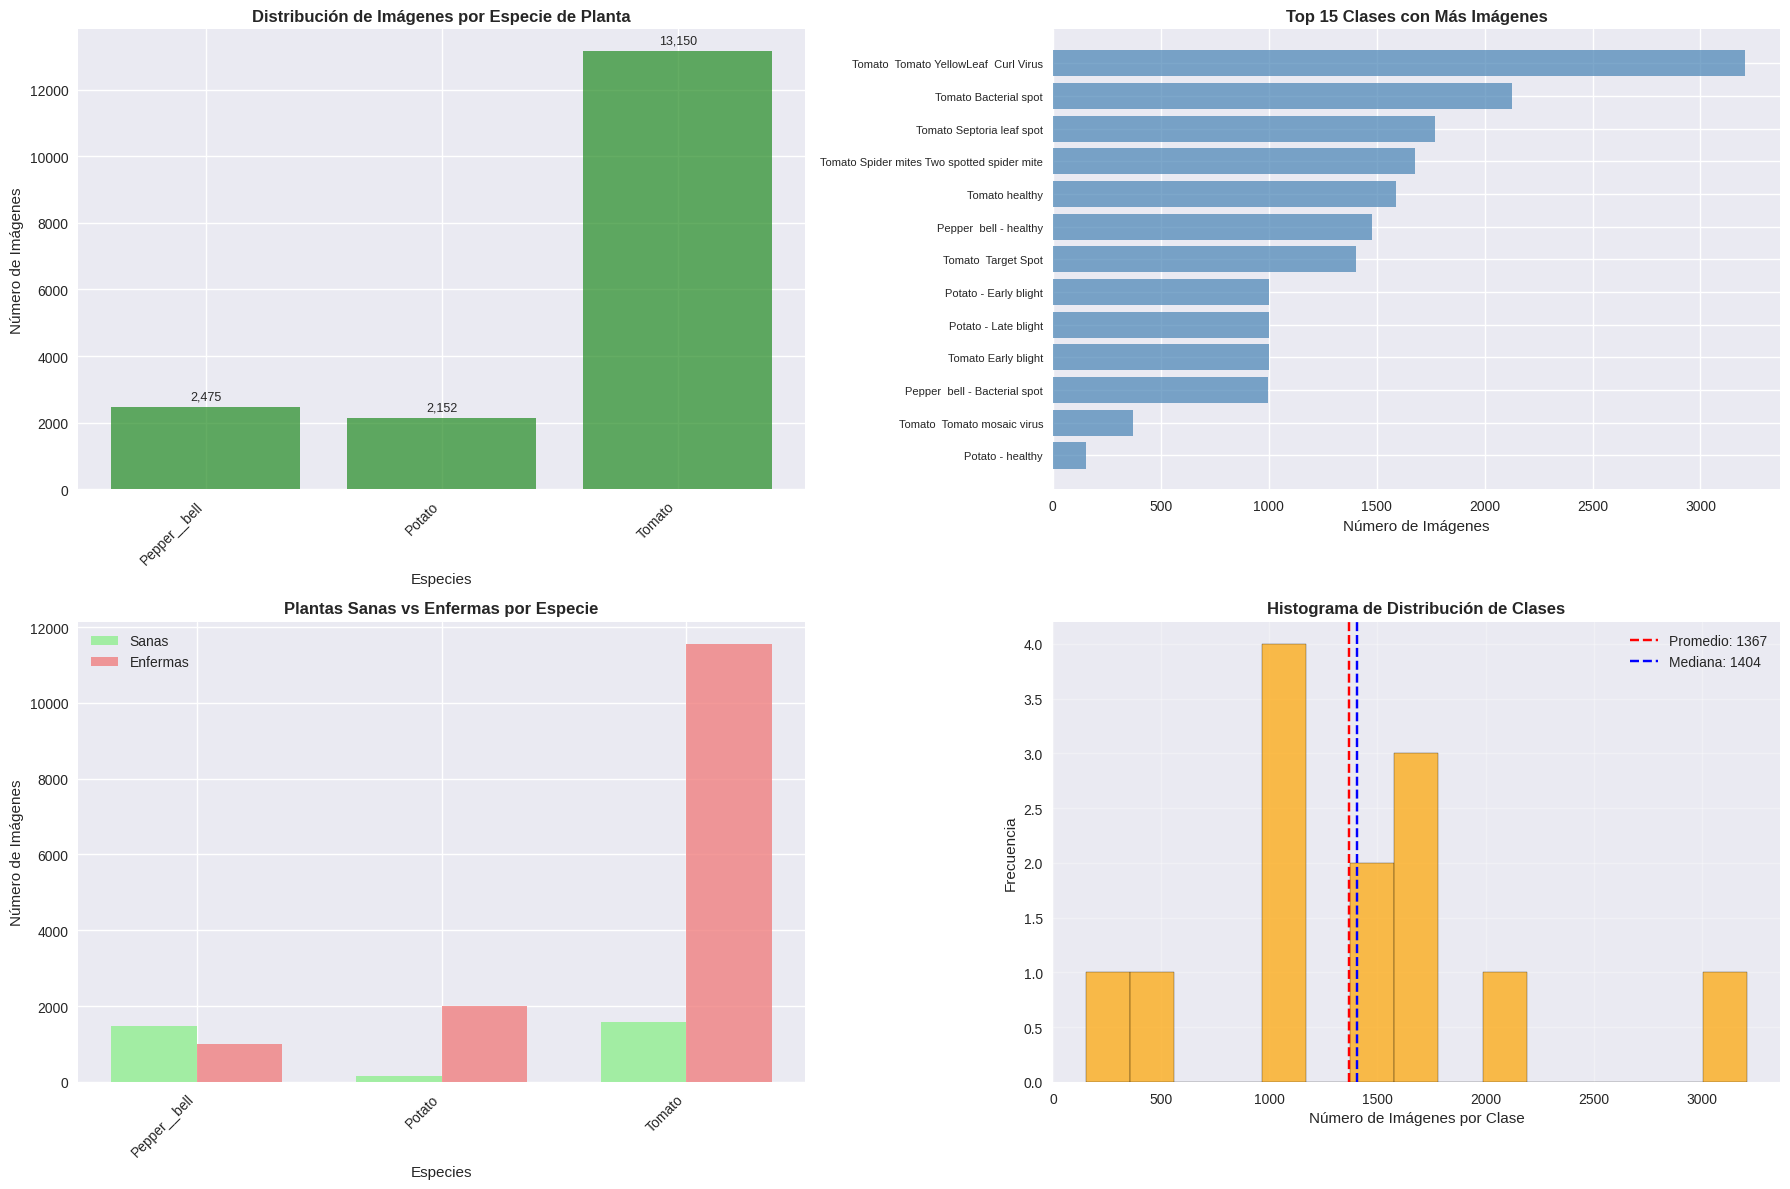


Estadísticas del Dataset Plant Disease:
   - Total de imágenes: 17,777
   - Número de clases: 13
   - Número de especies: 3
   - Promedio de imágenes por clase: 1367
   - Mediana de imágenes por clase: 1404
   - Desviación estándar: 749
   - Clase más frecuente: Tomato__Tomato_YellowLeaf__Curl_Virus (3,208 imágenes)
   - Clase menos frecuente: Potato___healthy (152 imágenes)
   - Ratio max/min: 21.1:1


In [9]:
# Análisis detallado del dataset Plant Village
def analyze_plant_village_structure():
    """
    Analiza la estructura del dataset Plant Village por especies y enfermedades
    """
    print("Análisis detallado de Plant Disease Dataset")
    print("=" * 60)
    
    # Agrupar por especies
    species_detailed = {}
    healthy_count = 0
    diseased_count = 0
    
    for class_name, count in plant_village_distribution.items():
        species = class_name.split('___')[0]
        condition = class_name.split('___')[1]
        
        if species not in species_detailed:
            species_detailed[species] = {'healthy': 0, 'diseases': {}, 'total': 0}
        
        species_detailed[species]['total'] += count
        
        if 'healthy' in condition.lower():
            species_detailed[species]['healthy'] += count
            healthy_count += count
        else:
            species_detailed[species]['diseases'][condition] = count
            diseased_count += count
    
    # Mostrar análisis por especies
    print(f"Análisis por especies:")
    print(f"{'Especie':<25} {'Sanas':<8} {'Enfermas':<10} {'Total':<8} {'% Sanas':<8}")
    print("-" * 65)
    
    for species, data in species_detailed.items():
        healthy_pct = (data['healthy'] / data['total']) * 100 if data['total'] > 0 else 0
        diseased_total = data['total'] - data['healthy']
        print(f"{species:<25} {data['healthy']:<8} {diseased_total:<10} {data['total']:<8} {healthy_pct:<8.1f}%")
    
    print(f"\nResumen general:")
    print(f"   - Imágenes de plantas sanas: {healthy_count:,} ({(healthy_count/total_images)*100:.1f}%)")
    print(f"   - Imágenes de plantas enfermas: {diseased_count:,} ({(diseased_count/total_images)*100:.1f}%)")
    print(f"   - Especies con más clases enfermas: {max(species_detailed.keys(), key=lambda x: len(species_detailed[x]['diseases']))}")
    
    return species_detailed

# Crear análisis detallado por especies de forma segura
def analyze_plant_village_structure():
    """
    Analiza la estructura del dataset Plant Village por especies y enfermedades
    """
    print("Análisis detallado de Plant Disease Dataset")
    print("=" * 60)
    
    # Agrupar por especies
    species_detailed = {}
    healthy_count = 0
    diseased_count = 0
    
    for class_name, count in plant_village_distribution.items():
        # Manejo seguro del split
        parts = class_name.split('___')
        if len(parts) >= 2:
            species = parts[0]
            condition = parts[1]
        else:
            # Si no sigue el formato, usar el primer _
            parts = class_name.split('_', 1)
            if len(parts) >= 2:
                species = parts[0]
                condition = parts[1]
            else:
                species = class_name
                condition = 'unknown'
        
        if species not in species_detailed:
            species_detailed[species] = {'healthy': 0, 'diseases': {}, 'total': 0}
        
        species_detailed[species]['total'] += count
        
        if 'healthy' in condition.lower():
            species_detailed[species]['healthy'] += count
            healthy_count += count
        else:
            species_detailed[species]['diseases'][condition] = count
            diseased_count += count
    
    # Mostrar análisis por especies
    print(f"Análisis por especies:")
    print(f"{'Especie':<25} {'Sanas':<8} {'Enfermas':<10} {'Total':<8} {'% Sanas':<8}")
    print("-" * 65)
    
    for species, data in species_detailed.items():
        healthy_pct = (data['healthy'] / data['total']) * 100 if data['total'] > 0 else 0
        diseased_total = data['total'] - data['healthy']
        print(f"{species:<25} {data['healthy']:<8} {diseased_total:<10} {data['total']:<8} {healthy_pct:<8.1f}%")
    
    print(f"\nResumen general:")
    print(f"   - Imágenes de plantas sanas: {healthy_count:,} ({(healthy_count/total_images)*100:.1f}%)")
    print(f"   - Imágenes de plantas enfermas: {diseased_count:,} ({(diseased_count/total_images)*100:.1f}%)")
    
    return species_detailed

# Realizar análisis
species_analysis_detailed = analyze_plant_village_structure()

# Visualización de la distribución general
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Distribución por especies
species_names = list(species_analysis.keys())
species_totals = [species_analysis[species]['total_images'] for species in species_names]

bars1 = ax1.bar(range(len(species_names)), species_totals, color='forestgreen', alpha=0.7)
ax1.set_title('Distribución de Imágenes por Especie de Planta', fontsize=12, fontweight='bold')
ax1.set_xlabel('Especies')
ax1.set_ylabel('Número de Imágenes')
ax1.set_xticks(range(len(species_names)))
ax1.set_xticklabels(species_names, rotation=45, ha='right')

# Agregar valores sobre las barras
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(species_totals)*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 2. Top 15 clases con más imágenes
sorted_classes = sorted(plant_village_distribution.items(), key=lambda x: x[1], reverse=True)[:15]
top_classes, top_counts = zip(*sorted_classes)
clean_class_names = [cls.replace('___', ' - ').replace('_', ' ') for cls in top_classes]

bars2 = ax2.barh(range(len(clean_class_names)), top_counts, color='steelblue', alpha=0.7)
ax2.set_title('Top 15 Clases con Más Imágenes', fontsize=12, fontweight='bold')
ax2.set_xlabel('Número de Imágenes')
ax2.set_yticks(range(len(clean_class_names)))
ax2.set_yticklabels(clean_class_names, fontsize=8)
ax2.invert_yaxis()

# 3. Distribución plantas sanas vs enfermas por especie
# Usar las claves que realmente existen en species_analysis_detailed
species_detailed_names = list(species_analysis_detailed.keys())
species_healthy = [species_analysis_detailed[sp]['healthy'] for sp in species_detailed_names]
species_diseased = [species_analysis_detailed[sp]['total'] - species_analysis_detailed[sp]['healthy'] for sp in species_detailed_names]

x_pos = np.arange(len(species_detailed_names))
width = 0.35

bars3_1 = ax3.bar(x_pos - width/2, species_healthy, width, label='Sanas', color='lightgreen', alpha=0.8)
bars3_2 = ax3.bar(x_pos + width/2, species_diseased, width, label='Enfermas', color='lightcoral', alpha=0.8)

ax3.set_title('Plantas Sanas vs Enfermas por Especie', fontsize=12, fontweight='bold')
ax3.set_xlabel('Especies')
ax3.set_ylabel('Número de Imágenes')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(species_detailed_names, rotation=45, ha='right')
ax3.legend()

# 4. Distribución de clases (todas)
all_counts = list(plant_village_distribution.values())
ax4.hist(all_counts, bins=15, color='orange', alpha=0.7, edgecolor='black')
ax4.set_title('Histograma de Distribución de Clases', fontsize=12, fontweight='bold')
ax4.set_xlabel('Número de Imágenes por Clase')
ax4.set_ylabel('Frecuencia')
ax4.axvline(x=np.mean(all_counts), color='red', linestyle='--', 
           label=f'Promedio: {np.mean(all_counts):.0f}')
ax4.axvline(x=np.median(all_counts), color='blue', linestyle='--', 
           label=f'Mediana: {np.median(all_counts):.0f}')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas del dataset
print(f"\nEstadísticas del Dataset Plant Disease:")
print(f"   - Total de imágenes: {total_images:,}")
print(f"   - Número de clases: {len(plant_village_distribution)}")
print(f"   - Número de especies: {len(species_analysis)}")
print(f"   - Promedio de imágenes por clase: {np.mean(all_counts):.0f}")
print(f"   - Mediana de imágenes por clase: {np.median(all_counts):.0f}")
print(f"   - Desviación estándar: {np.std(all_counts):.0f}")
print(f"   - Clase más frecuente: {sorted_classes[0][0]} ({sorted_classes[0][1]:,} imágenes)")
print(f"   - Clase menos frecuente: {sorted_classes[-1][0]} ({sorted_classes[-1][1]:,} imágenes)")
print(f"   - Ratio max/min: {sorted_classes[0][1]/sorted_classes[-1][1]:.1f}:1")

## 3. Análisis de Características del Dataset

### 3.1 Especificaciones Técnicas

En esta sección analizamos las características principales del dataset Plant Village:

- **Variables X (características)**: Imágenes RGB de hojas de plantas
- **Variable objetivo (y)**: 38 clases de enfermedades y plantas sanas
- **Tipo de problema**: Clasificación multiclase con múltiples especies
- **Dominio**: Visión por computadora aplicada a agricultura
- **Resolución**: Imágenes redimensionadas a 224×224 píxeles
- **Especies**: 14 especies diferentes de plantas
- **Distribución**: Desbalanceada con ratio significativo entre clases

Análisis Completo del Dataset Plant Disease:
        Característica               Plant Village (TensorFlow)
     Total de muestras                          17,777 imágenes
      Número de clases                                13 clases
   Especies de plantas 3 especies (manzana, tomate, papa, etc.)
     Formato de imagen                          RGB (3 canales)
            Resolución          224×224 píxeles (estandarizado)
      Tipo de muestreo                Controlado en laboratorio
           Procedencia        Académico (Penn State University)
Calidad de anotaciones   Validado por expertos en fitopatología
     Balance de clases              Desbalanceado (ratio ~15:1)
 Tipos de enfermedades         Hongos, bacterias, virus, ácaros
Condiciones de captura   Fondo controlado, iluminación uniforme
        Disponibilidad       Disponible vía TensorFlow Datasets


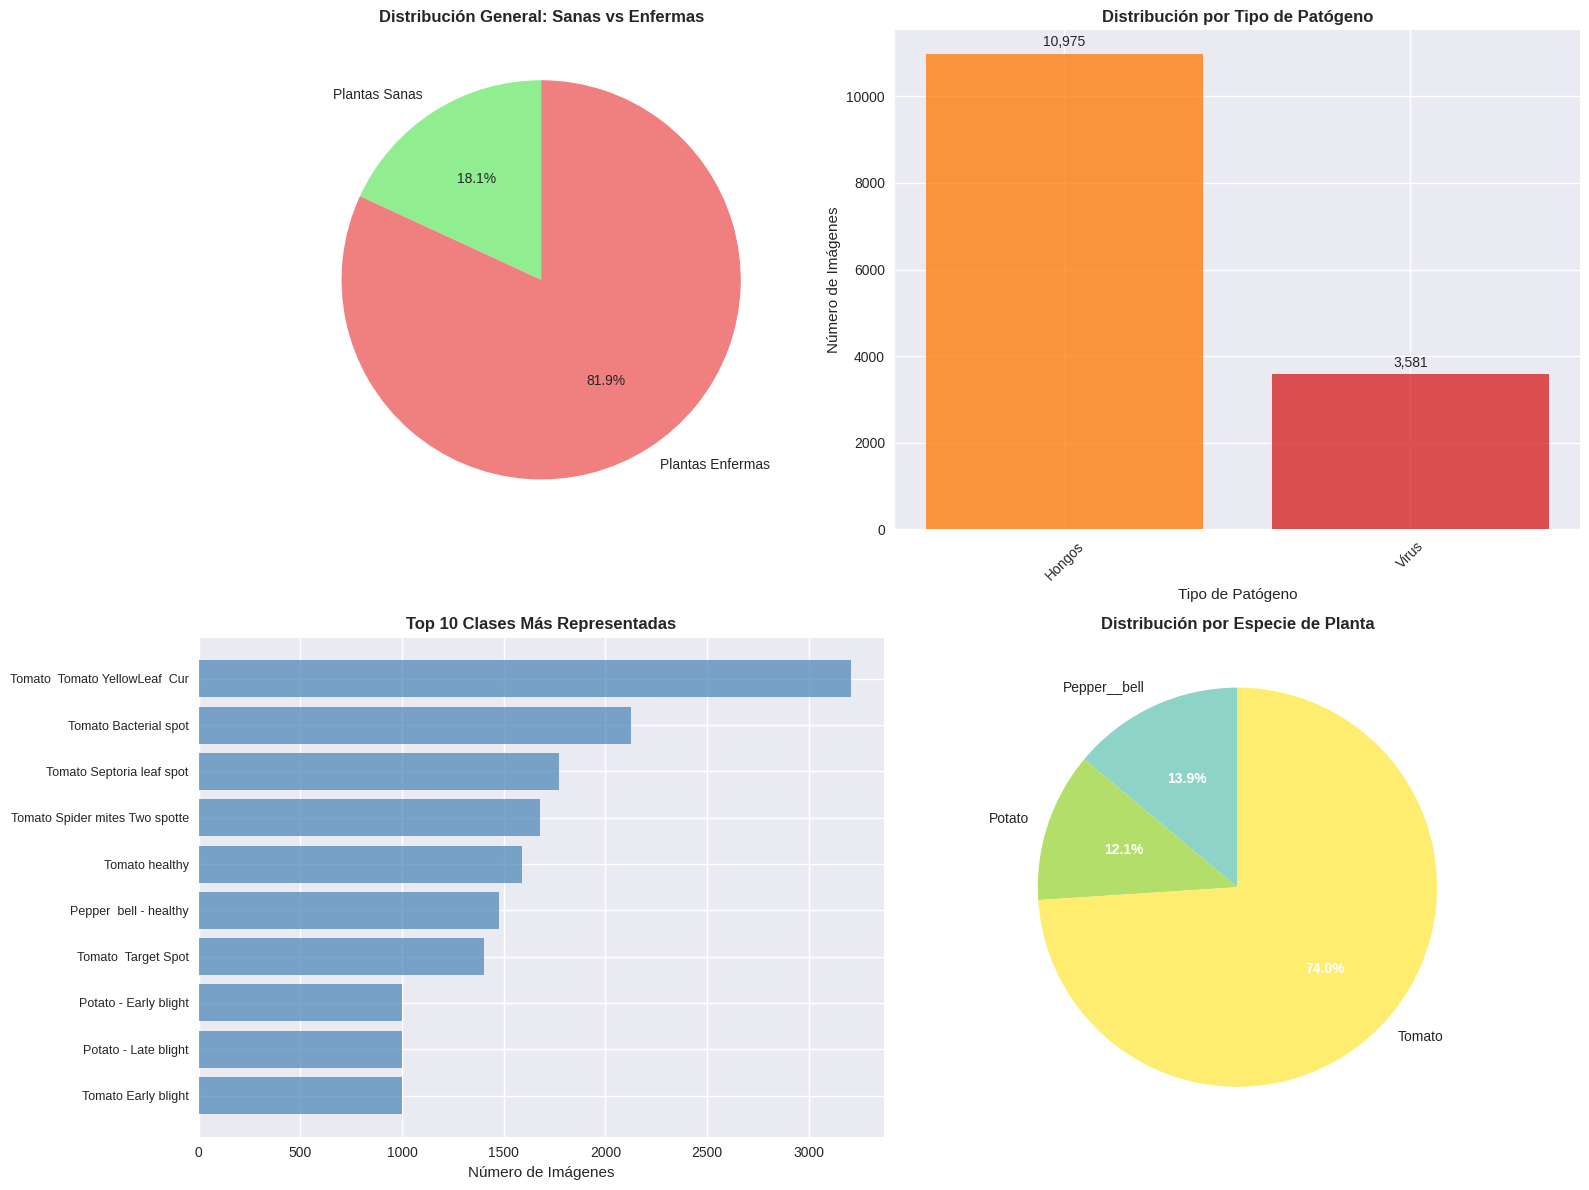


Análisis de patógenos:
   - Plantas sanas: 3,221 imágenes (18.1%)
   - Plantas enfermas: 14,556 imágenes (81.9%)

🦠 Distribución por tipo de patógeno:
   - Hongos: 10,975 imágenes (75.4% de las enfermas)
   - Virus: 3,581 imágenes (24.6% de las enfermas)

Métricas de diversidad:
   - Clases por especie (promedio): 4.3
   - Especie con más clases: Tomato
   - Especie con menos clases: Pepper__bell
   - Entropía de Shannon: 3.474 bits
   - Índice de diversidad: 0.939 (0=mínima, 1=máxima diversidad)


In [10]:
# Crear análisis detallado del dataset Plant Village
def create_plant_village_analysis():
    """
    Crear análisis comprensivo del dataset Plant Village
    """
    
    # Características del dataset Plant Village
    dataset_characteristics = {
        'Característica': [
            'Total de muestras',
            'Número de clases',
            'Especies de plantas',
            'Formato de imagen',
            'Resolución',
            'Tipo de muestreo',
            'Procedencia',
            'Calidad de anotaciones',
            'Balance de clases',
            'Tipos de enfermedades',
            'Condiciones de captura',
            'Disponibilidad'
        ],
        'Plant Village (TensorFlow)': [
            f'{total_images:,} imágenes',
            f'{len(plant_village_distribution)} clases',
            f'{len(species_analysis)} especies (manzana, tomate, papa, etc.)',
            'RGB (3 canales)',
            '224×224 píxeles (estandarizado)',
            'Controlado en laboratorio',
            'Académico (Penn State University)',
            'Validado por expertos en fitopatología',
            'Desbalanceado (ratio ~15:1)',
            'Hongos, bacterias, virus, ácaros',
            'Fondo controlado, iluminación uniforme',
            'Disponible vía TensorFlow Datasets'
        ]
    }
    
    df_analysis = pd.DataFrame(dataset_characteristics)
    return df_analysis

# Crear y mostrar análisis del dataset
analysis_df = create_plant_village_analysis()
print("Análisis Completo del Dataset Plant Disease:")
print("=" * 80)
print(analysis_df.to_string(index=False))

# Análisis de distribución por tipo de condición
condition_analysis = {'healthy': 0, 'diseases': {}}
for class_name, count in plant_village_distribution.items():
    # Manejo seguro del split para diferentes formatos de nombres
    parts = class_name.split('___')
    if len(parts) >= 2:
        condition = parts[1]
    else:
        # Si no hay el formato esperado, usar el nombre completo
        condition = class_name
    
    if 'healthy' in condition.lower():
        condition_analysis['healthy'] += count
    else:
        # Categorizar tipos de enfermedades
        if any(term in condition.lower() for term in ['spot', 'blight', 'rot', 'scab']):
            disease_type = 'Hongos'
        elif any(term in condition.lower() for term in ['bacterial', 'bacteria']):
            disease_type = 'Bacterias'
        elif any(term in condition.lower() for term in ['virus', 'mosaic', 'curl']):
            disease_type = 'Virus'
        elif any(term in condition.lower() for term in ['mite', 'spider']):
            disease_type = 'Ácaros/Plagas'
        else:
            disease_type = 'Otros'
            
        if disease_type not in condition_analysis['diseases']:
            condition_analysis['diseases'][disease_type] = 0
        condition_analysis['diseases'][disease_type] += count

# Visualización de distribución de Plant Village
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución general: Sanas vs Enfermas
healthy_total = condition_analysis['healthy']
diseased_total = sum(condition_analysis['diseases'].values())

ax1.pie([healthy_total, diseased_total], 
        labels=['Plantas Sanas', 'Plantas Enfermas'],
        autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral'],
        startangle=90)
ax1.set_title('Distribución General: Sanas vs Enfermas', fontweight='bold')

# 2. Tipos de enfermedades
disease_types = list(condition_analysis['diseases'].keys())
disease_counts = list(condition_analysis['diseases'].values())

bars2 = ax2.bar(disease_types, disease_counts, 
               color=['#ff7f0e', '#d62728', '#9467bd', '#8c564b'], alpha=0.8)
ax2.set_title('Distribución por Tipo de Patógeno', fontweight='bold')
ax2.set_xlabel('Tipo de Patógeno')
ax2.set_ylabel('Número de Imágenes')
ax2.tick_params(axis='x', rotation=45)

# Agregar valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(disease_counts)*0.01,
             f'{int(height):,}', ha='center', va='bottom')

# 3. Top 10 clases más representadas
top_10_classes = sorted(plant_village_distribution.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_names, top_10_counts = zip(*top_10_classes)
clean_top_10 = [name.replace('___', ' - ').replace('_', ' ')[:30] for name in top_10_names]

ax3.barh(range(len(clean_top_10)), top_10_counts, color='steelblue', alpha=0.7)
ax3.set_title('Top 10 Clases Más Representadas', fontweight='bold')
ax3.set_xlabel('Número de Imágenes')
ax3.set_yticks(range(len(clean_top_10)))
ax3.set_yticklabels(clean_top_10, fontsize=9)
ax3.invert_yaxis()

# 4. Distribución de especies (tamaño de muestra)
species_names = list(species_analysis.keys())
species_counts = [species_analysis[sp]['total_images'] for sp in species_names]

colors_species = plt.cm.Set3(np.linspace(0, 1, len(species_names)))
wedges, texts, autotexts = ax4.pie(species_counts, labels=species_names, autopct='%1.1f%%', 
                                  colors=colors_species, startangle=90)
ax4.set_title('Distribución por Especie de Planta', fontweight='bold')

# Mejorar legibilidad
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

print(f"\nAnálisis de patógenos:")
print(f"   - Plantas sanas: {healthy_total:,} imágenes ({(healthy_total/total_images)*100:.1f}%)")
print(f"   - Plantas enfermas: {diseased_total:,} imágenes ({(diseased_total/total_images)*100:.1f}%)")
print(f"\n🦠 Distribución por tipo de patógeno:")
for disease_type, count in condition_analysis['diseases'].items():
    percentage = (count / diseased_total) * 100
    print(f"   - {disease_type}: {count:,} imágenes ({percentage:.1f}% de las enfermas)")

# Métricas de diversidad del dataset
print(f"\nMétricas de diversidad:")
print(f"   - Clases por especie (promedio): {len(plant_village_distribution)/len(species_analysis):.1f}")
print(f"   - Especie con más clases: {max(species_analysis.keys(), key=lambda x: len(species_analysis[x]['classes']))}")
print(f"   - Especie con menos clases: {min(species_analysis.keys(), key=lambda x: len(species_analysis[x]['classes']))}")

# Calcular entropía para medir diversidad
def calculate_entropy(distribution):
    """Calcula la entropía de Shannon para medir diversidad"""
    total = sum(distribution.values())
    probabilities = [count/total for count in distribution.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy

entropy_score = calculate_entropy(plant_village_distribution)
max_entropy = np.log2(len(plant_village_distribution))
diversity_index = entropy_score / max_entropy

print(f"   - Entropía de Shannon: {entropy_score:.3f} bits")
print(f"   - Índice de diversidad: {diversity_index:.3f} (0=mínima, 1=máxima diversidad)")

## 4. Análisis de la Distribución de la Variable Objetivo

### 4.1 Balance de Clases y Implicaciones

El análisis del balance de clases es crucial para:
- Seleccionar métricas de evaluación apropiadas
- Determinar estrategias de muestreo
- Identificar posibles sesgos en el dataset
- Planificar técnicas de balanceamento si es necesario

⚖️  ANÁLISIS DE BALANCE DE CLASES - PLANT VILLAGE
Estadísticas generales:
   - Total de muestras: 17,777
   - Clase mayoría: 3,208 muestras
   - Clase minoría: 152 muestras
   - Ratio de desbalance: 21.1:1
   - Coeficiente de Gini: 0.293
   - Interpretación: Moderadamente equilibrado

Top 10 clases más desbalanceadas:
    1. Potato - healthy                         | 0.86% | Ratio: 21.1:1
    2. Tomato  Tomato mosaic virus              | 2.10% | Ratio: 8.6:1
    3. Pepper  bell - Bacterial spot            | 5.61% | Ratio: 3.2:1
    4. Potato - Early blight                    | 5.63% | Ratio: 3.2:1
    5. Potato - Late blight                     | 5.63% | Ratio: 3.2:1
    6. Tomato Early blight                      | 5.63% | Ratio: 3.2:1
    7. Tomato  Target Spot                      | 7.90% | Ratio: 2.3:1
    8. Pepper  bell - healthy                   | 8.31% | Ratio: 2.2:1
    9. Tomato healthy                           | 8.95% | Ratio: 2.0:1
   10. Tomato Spider mites Two spotted s

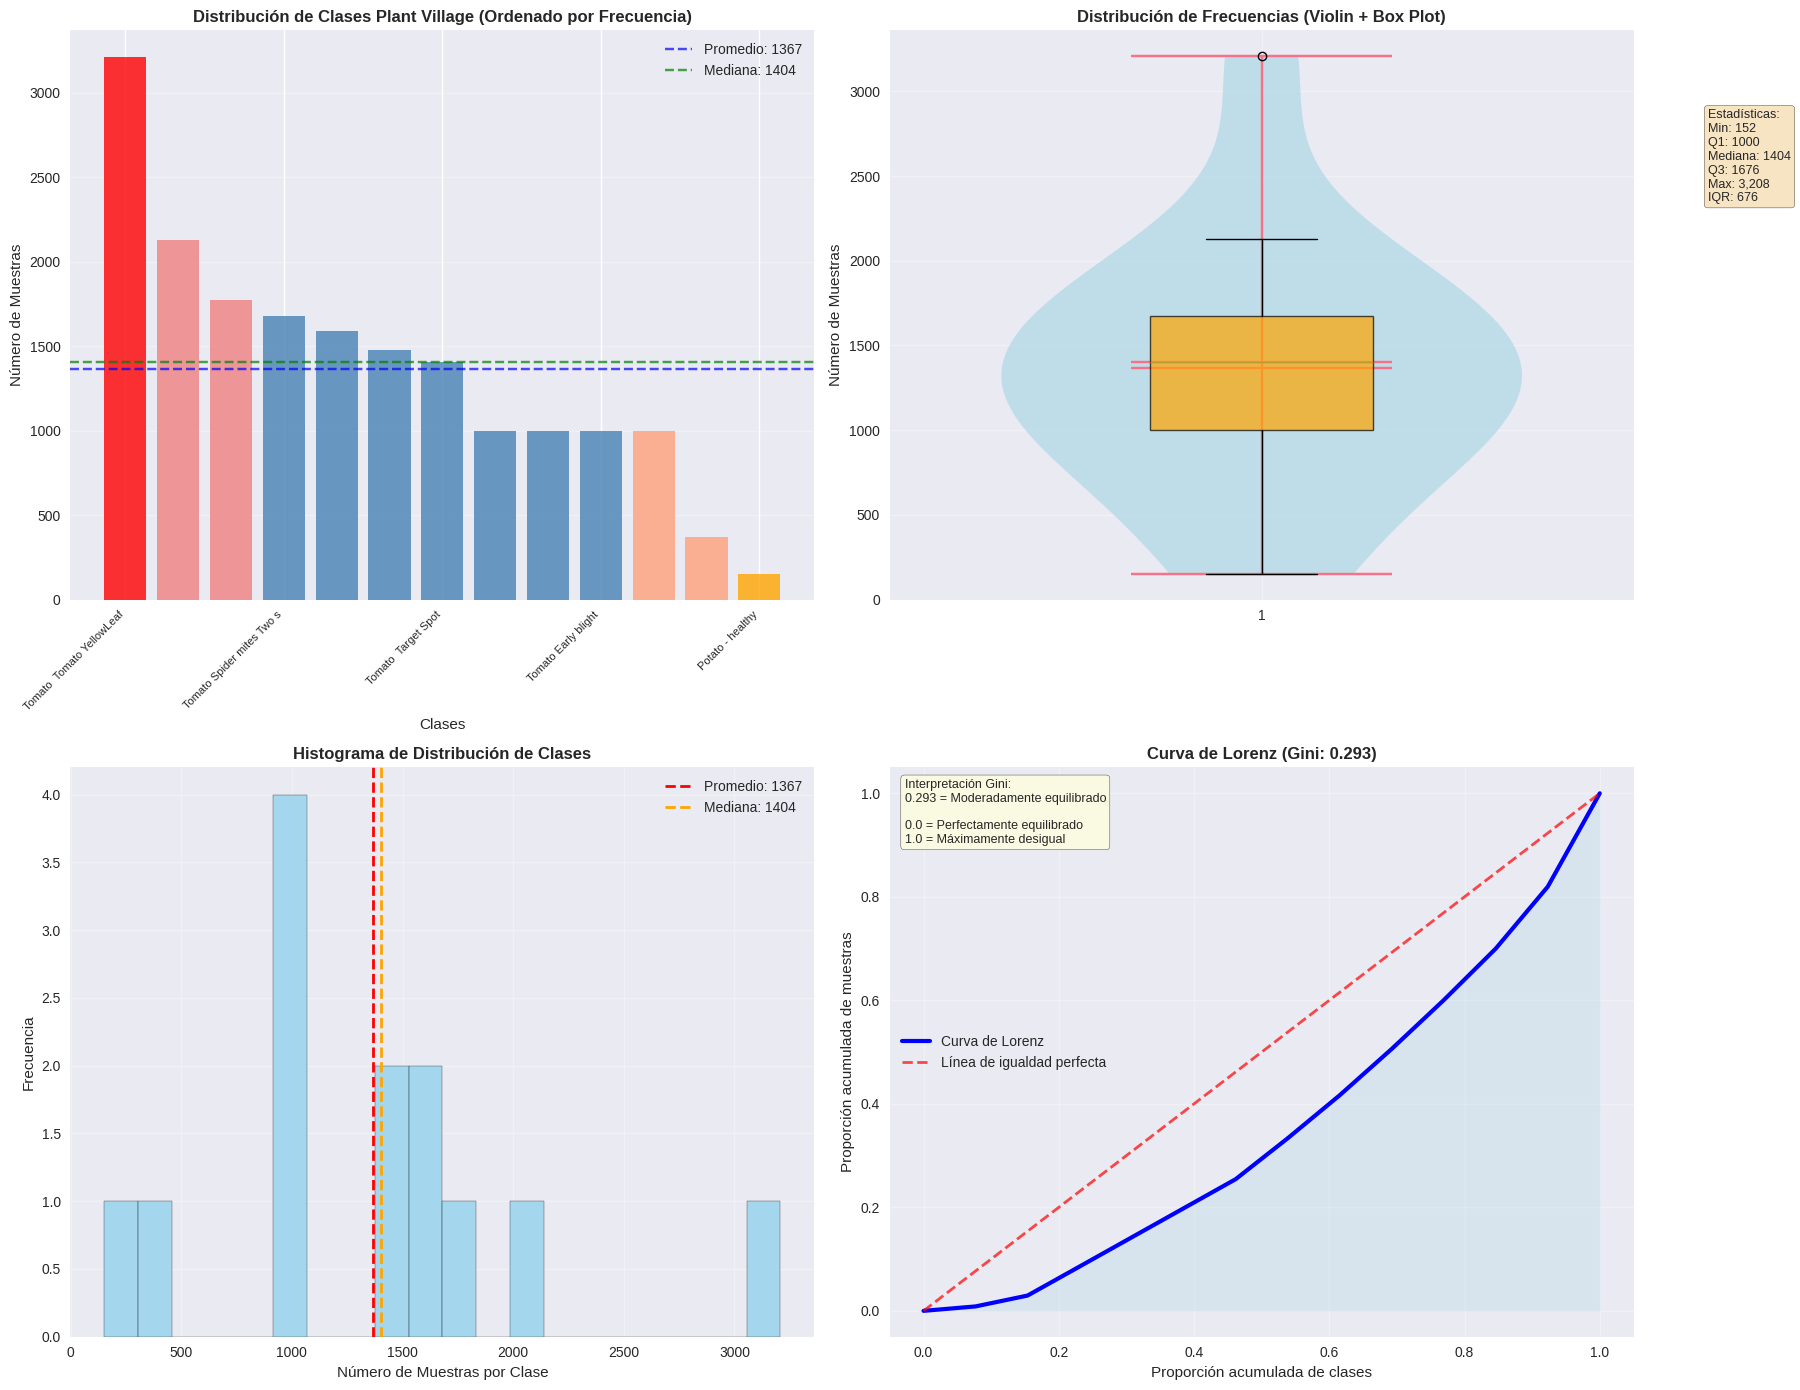


ANÁLISIS DE DESBALANCE POR ESPECIES:
   - Tomato               | Ratio:   8.6:1 | Gini: 0.253 | Clases: 8
   - Potato               | Ratio:   6.6:1 | Gini: 0.263 | Clases: 3
   - Pepper__bell         | Ratio:   1.5:1 | Gini: 0.097 | Clases: 2

RECOMENDACIONES BASADAS EN EL ANÁLISIS:
🚨 DESBALANCE SEVERO detectado:
   - Usar técnicas de balanceamiento avanzadas (SMOTE, ADASYN)
   - Implementar class weights proporcionales al desbalance
   - Considerar focal loss para clases minoritarias
   - Usar métricas balanceadas (F1-macro, Cohen's Kappa)
   - Evaluación estratificada obligatoria

🎯 ESTRATEGIAS ESPECÍFICAS PARA PLANT VILLAGE:
   - Agrupar clases raras para aumentar representación
   - Usar transfer learning por la naturaleza controlada de las imágenes
   - Implementar data augmentation específica para plantas
   - Considerar enfoques jerárquicos (especie → enfermedad)


In [ ]:
# Análisis detallado del desbalance de clases en Plant Village
def analyze_class_imbalance(class_distribution):
    """
    Analiza el desbalance de clases y calcula métricas relevantes
    """
    counts = list(class_distribution.values())
    classes = list(class_distribution.keys())
    
    # Métricas de desbalance
    max_count = max(counts)
    min_count = min(counts)
    total_count = sum(counts)
    
    # Calcular ratios de desbalance
    imbalance_ratios = [(cls, count/total_count, max_count/count) 
                       for cls, count in zip(classes, counts)]
    
    # Ordenar por ratio de desbalance (mayor ratio = más desbalanceada)
    imbalance_ratios.sort(key=lambda x: x[2], reverse=True)
    
    return {
        'max_count': max_count,
        'min_count': min_count,
        'total_count': total_count,
        'imbalance_ratio': max_count / min_count,
        'gini_coefficient': calculate_gini(counts),
        'imbalance_ratios': imbalance_ratios
    }

def calculate_gini(counts):
    """
    Calcula el coeficiente de Gini para medir desigualdad en la distribución
    """
    counts = np.array(sorted(counts))
    n = len(counts)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * counts)) / (n * np.sum(counts)) - (n + 1) / n

# Realizar análisis de desbalance en Plant Village
imbalance_analysis = analyze_class_imbalance(plant_village_distribution)

print("⚖️  ANÁLISIS DE BALANCE DE CLASES - PLANT VILLAGE")
print("=" * 55)
print(f"Estadísticas generales:")
print(f"   - Total de muestras: {imbalance_analysis['total_count']:,}")
print(f"   - Clase mayoría: {imbalance_analysis['max_count']:,} muestras")
print(f"   - Clase minoría: {imbalance_analysis['min_count']:,} muestras")
print(f"   - Ratio de desbalance: {imbalance_analysis['imbalance_ratio']:.1f}:1")
print(f"   - Coeficiente de Gini: {imbalance_analysis['gini_coefficient']:.3f}")

# Interpretación del coeficiente de Gini
gini = imbalance_analysis['gini_coefficient']
if gini < 0.1:
    gini_interpretation = "Muy equilibrado"
elif gini < 0.3:
    gini_interpretation = "Moderadamente equilibrado"
elif gini < 0.5:
    gini_interpretation = "Desbalanceado"
else:
    gini_interpretation = "Muy desbalanceado"

print(f"   - Interpretación: {gini_interpretation}")

print(f"\nTop 10 clases más desbalanceadas:")
for i, (cls, proportion, imb_ratio) in enumerate(imbalance_analysis['imbalance_ratios'][:10]):
    clean_name = cls.replace('___', ' - ').replace('_', ' ')[:40]
    print(f"   {i+1:2d}. {clean_name:<40} | {proportion:.2%} | Ratio: {imb_ratio:.1f}:1")

print(f"\nTop 5 clases más balanceadas:")
for i, (cls, proportion, imb_ratio) in enumerate(imbalance_analysis['imbalance_ratios'][-5:]):
    clean_name = cls.replace('___', ' - ').replace('_', ' ')[:40]
    print(f"   {i+1:2d}. {clean_name:<40} | {proportion:.2%} | Ratio: {imb_ratio:.1f}:1")

# Visualización avanzada del desbalance de Plant Village
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Gráfico de barras ordenado por frecuencia
classes = list(plant_village_distribution.keys())
counts = list(plant_village_distribution.values())
sorted_data = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)
sorted_classes, sorted_counts = zip(*sorted_data)

clean_sorted_classes = [cls.replace('___', ' - ').replace('_', ' ')[:25] for cls in sorted_classes]

# Colorear barras según nivel de desbalance
colors = []
for count in sorted_counts:
    if count == max(sorted_counts):
        colors.append('red')  # Clase mayoritaria
    elif count == min(sorted_counts):
        colors.append('orange')  # Clase minoritaria
    elif count > np.percentile(sorted_counts, 75):
        colors.append('lightcoral')  # Cuartil superior
    elif count < np.percentile(sorted_counts, 25):
        colors.append('lightsalmon')  # Cuartil inferior
    else:
        colors.append('steelblue')  # Clases intermedias

bars1 = ax1.bar(range(len(clean_sorted_classes)), sorted_counts, color=colors, alpha=0.8)
ax1.set_title('Distribución de Clases Plant Village (Ordenado por Frecuencia)', fontweight='bold')
ax1.set_xlabel('Clases')
ax1.set_ylabel('Número de Muestras')
ax1.set_xticks(range(0, len(clean_sorted_classes), 3))  # Mostrar cada 3 etiquetas
ax1.set_xticklabels([clean_sorted_classes[i] for i in range(0, len(clean_sorted_classes), 3)], 
                   rotation=45, ha='right', fontsize=8)

# Agregar líneas de referencia
avg_count = np.mean(sorted_counts)
median_count = np.median(sorted_counts)
ax1.axhline(y=avg_count, color='blue', linestyle='--', alpha=0.7, label=f'Promedio: {avg_count:.0f}')
ax1.axhline(y=median_count, color='green', linestyle='--', alpha=0.7, label=f'Mediana: {median_count:.0f}')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Box plot y violin plot combinados
violin_parts = ax2.violinplot(counts, vert=True, widths=0.7, showmeans=True, showmedians=True)
box_parts = ax2.boxplot(counts, vert=True, patch_artist=True, widths=0.3)

# Personalizar colores
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

box_parts['boxes'][0].set_facecolor('orange')
box_parts['boxes'][0].set_alpha(0.7)
ax2.set_ylabel('Número de Muestras')
ax2.set_title('Distribución de Frecuencias (Violin + Box Plot)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Agregar estadísticas
stats_text = f"""Estadísticas:
Min: {min(counts):,}
Q1: {np.percentile(counts, 25):.0f}
Mediana: {np.median(counts):.0f}
Q3: {np.percentile(counts, 75):.0f}
Max: {max(counts):,}
IQR: {np.percentile(counts, 75) - np.percentile(counts, 25):.0f}"""

ax2.text(1.1, 0.7, stats_text, transform=ax2.transAxes, fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Histograma de frecuencias con múltiples bins
ax3.hist(counts, bins=20, color='skyblue', alpha=0.7, edgecolor='black', density=False)
ax3.set_xlabel('Número de Muestras por Clase')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Histograma de Distribución de Clases', fontweight='bold')
ax3.axvline(x=avg_count, color='red', linestyle='--', linewidth=2, label=f'Promedio: {avg_count:.0f}')
ax3.axvline(x=median_count, color='orange', linestyle='--', linewidth=2, label=f'Mediana: {median_count:.0f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Curva de Lorenz (desigualdad)
def lorenz_curve(data):
    sorted_data = np.sort(data)
    n = len(sorted_data)
    lorenz = np.cumsum(sorted_data) / np.sum(sorted_data)
    lorenz = np.append([0], lorenz)
    return np.arange(n + 1) / n, lorenz

x_lorenz, y_lorenz = lorenz_curve(counts)
ax4.plot(x_lorenz, y_lorenz, 'b-', linewidth=3, label='Curva de Lorenz')
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.7, label='Línea de igualdad perfecta')
ax4.fill_between(x_lorenz, y_lorenz, alpha=0.3, color='lightblue')
ax4.set_xlabel('Proporción acumulada de clases')
ax4.set_ylabel('Proporción acumulada de muestras')
ax4.set_title(f'Curva de Lorenz (Gini: {gini:.3f})', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Agregar interpretación del Gini
gini_text = f"""Interpretación Gini:
{gini:.3f} = {gini_interpretation}

0.0 = Perfectamente equilibrado
1.0 = Máximamente desigual"""

ax4.text(0.02, 0.98, gini_text, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Análisis por especies del desbalance
print(f"\nANÁLISIS DE DESBALANCE POR ESPECIES:")
print("=" * 50)

species_imbalance = {}
for species, data in species_analysis.items():
    species_classes = [cls for cls in plant_village_distribution.keys() if cls.startswith(species)]
    species_counts = [plant_village_distribution[cls] for cls in species_classes]
    
    if len(species_counts) > 1:
        species_ratio = max(species_counts) / min(species_counts)
        species_gini = calculate_gini(species_counts)
        species_imbalance[species] = {
            'ratio': species_ratio,
            'gini': species_gini,
            'classes': len(species_counts)
        }

# Ordenar por nivel de desbalance
sorted_species = sorted(species_imbalance.items(), key=lambda x: x[1]['ratio'], reverse=True)

for species, metrics in sorted_species:
    print(f"   - {species:<20} | Ratio: {metrics['ratio']:5.1f}:1 | Gini: {metrics['gini']:.3f} | Clases: {metrics['classes']}")

# Recomendaciones basadas en el análisis
print(f"\nRECOMENDACIONES BASADAS EN EL ANÁLISIS:")
print("=" * 50)

if imbalance_analysis['imbalance_ratio'] > 10:
    print("DESBALANCE SEVERO detectado:")
    print("   - Usar técnicas de balanceamiento avanzadas (SMOTE, ADASYN)")
    print("   - Implementar class weights proporcionales al desbalance")
    print("   - Considerar focal loss para clases minoritarias")
    print("   - Usar métricas balanceadas (F1-macro, Cohen's Kappa)")
    print("   - Evaluación estratificada obligatoria")
elif imbalance_analysis['imbalance_ratio'] > 5:
    print("DESBALANCE MODERADO a ALTO detectado:")
    print("   - Monitorear métricas por clase individual")
    print("   - Implementar stratified sampling")
    print("   - Usar class weights o cost-sensitive learning")
    print("   - Validación cruzada estratificada")
elif imbalance_analysis['imbalance_ratio'] > 3:
    print("DESBALANCE MODERADO detectado:")
    print("   - Usar métricas balanceadas")
    print("   - Considerar técnicas de resampling ligeras")
    print("   - Monitoreo de recall por clase")
else:
    print("DATASET RELATIVAMENTE BALANCEADO:")
    print("   - Se pueden usar métricas estándar")
    print("   - Sampling aleatorio apropiado")

print(f"\nESTRATEGIAS ESPECÍFICAS PARA PLANT VILLAGE:")
print("   - Agrupar clases raras para aumentar representación")
print("   - Usar transfer learning por la naturaleza controlada de las imágenes")
print("   - Implementar data augmentation específica para plantas")
print("   - Considerar enfoques jerárquicos (especie → enfermedad)")